# Solution 2 

In [1]:
pip install pennylane

     |████████████████████████████████| 1.7 MB 5.4 MB/s eta 0:00:01
  Using cached toml-0.10.2-py2.py3-none-any.whl (16 kB)
  Using cached appdirs-1.4.4-py2.py3-none-any.whl (9.6 kB)
     |████████████████████████████████| 50 kB 4.1 MB/s eta 0:00:011
     |████████████████████████████████| 49 kB 3.9 MB/s eta 0:00:01
     |████████████████████████████████| 121 kB 6.7 MB/s eta 0:00:01
  Using cached semantic_version-2.10.0-py2.py3-none-any.whl (15 kB)
     |████████████████████████████████| 491 kB 7.6 MB/s eta 0:00:01
You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


Plot the error $|\langle O\rangle_{\text{classical shadows}} -  \langle O \rangle_{\text{exact}}|$  by increasing the number of samples used to estimate the expectation values. Discuss the relationship between the error and the number of samples.

In [2]:
import pennylane as qml
import pennylane.numpy as np
import matplotlib.pyplot as plt
import time
from scipy.linalg import eigh

In [3]:
def calculate_classical_shadow(circuit_template, params, shadow_size, num_qubits):
    
    # applying the single-qubit Clifford circuit is equivalent to measuring a Pauli
    unitary_ensemble = [qml.PauliX, qml.PauliY, qml.PauliZ]

    # sample random Pauli measurements uniformly, where 0,1,2 = X,Y,Z
    unitary_ids = np.random.randint(0, 3, size=(shadow_size, num_qubits))
    outcomes = np.zeros((shadow_size, num_qubits))

    for ns in range(shadow_size):
        # for each snapshot, add a random Pauli observable at each location
        obs = [unitary_ensemble[int(unitary_ids[ns, i])](i) for i in range(num_qubits)]
        outcomes[ns, :] = circuit_template(params, observable=obs)

    # combine the computational basis outcomes and the sampled unitaries
    return (outcomes, unitary_ids)


In [4]:
def snapshot_state(b_list, obs_list):
    
    num_qubits = len(b_list)

    # computational basis states
    zero_state = np.array([[1, 0], [0, 0]])
    one_state = np.array([[0, 0], [0, 1]])

    # local qubit unitaries
    phase_z = np.array([[1, 0], [0, -1j]], dtype=complex)
    hadamard = qml.matrix(qml.Hadamard(0))
    identity = qml.matrix(qml.Identity(0))

    # undo the rotations that were added implicitly to the circuit for the Pauli measurements
    unitaries = [hadamard, hadamard @ phase_z, identity]

    # reconstructing the snapshot state from local Pauli measurements
    rho_snapshot = [1]
    for i in range(num_qubits):
        state = zero_state if b_list[i] == 1 else one_state
        U = unitaries[int(obs_list[i])]

        # applying Eq. (S44)
        local_rho = 3 * (U.conj().T @ state @ U) - identity
        rho_snapshot = np.kron(rho_snapshot, local_rho)

    return rho_snapshot

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pennylane/numpy/tensor.py:155: RuntimeWarning: invalid value encountered in divide
  res = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/var/folders/qw/nqzbh1nx5qgdh1mgbkmlw8j40000gn/T/ipykernel_2784/2639938852.py:32: ComplexWarning: Casting complex values to real discards the imaginary part
  outputset[m] = np.trace(nearest_density_matrix((rho_estimate[m])).dot(Observable))


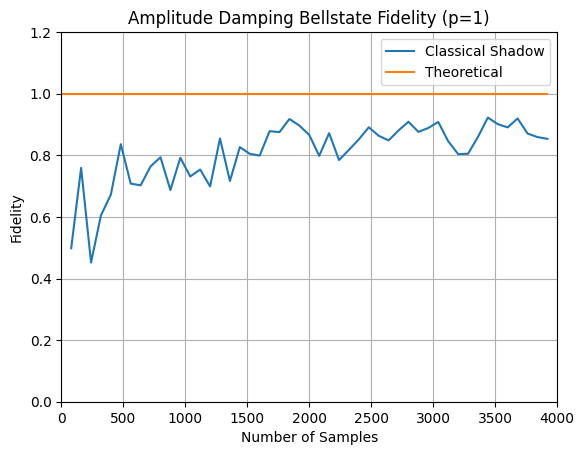

In [5]:
def nearest_density_matrix(matrix):
    """
    Estimate the nearest physical density matrix to a given matrix.
    Ensures the matrix is Hermitian, positive semi-definite, and has trace one.
    """
    # Ensure the matrix is Hermitian
    matrix = (matrix + matrix.conj().T) / 2

    # Eigenvalue decomposition
    eigenvalues, eigenvectors = eigh(matrix)

    # Set negative eigenvalues to zero (project onto the space of positive semi-definite matrices)
    eigenvalues = np.clip(eigenvalues, a_min=0, a_max=None)

    # Reconstruct the matrix with the non-negative eigenvalues
    matrix_psd = eigenvectors @ np.diag(eigenvalues) @ eigenvectors.conj().T

    # Normalize the matrix so that its trace equals one
    density_matrix = matrix_psd / np.trace(matrix_psd)

    return density_matrix

def median_of_means(shadow_rho,K,Observable):
    rho_estimate = np.zeros((K,2**num_qubits,2**num_qubits),dtype=complex)
    n = shadow_rho.shape[0]//K
    for i in range(K):
        for j in range((K-1)*n+1, K*n):
            rho_estimate[i] += shadow_rho[j]/n
    outputset = np.zeros((K,1))
  
    for m in range(K):
        outputset[m] = np.trace(nearest_density_matrix((rho_estimate[m])).dot(Observable))

    output = np.median(outputset)
    return output



p = 1
num_qubits = 2
dev = qml.device('default.mixed', wires=num_qubits, shots=1)
@qml.qnode(dev)

def bell_state_circuit(params,**kwargs):
    observables = kwargs.pop("observable")
    qml.Hadamard(0)
    qml.CNOT(wires=[0,1]) 
    qml.BitFlip(p,wires=0)
    qml.BitFlip(p,wires=1)
    return [qml.expval(o) for o in observables]

params = []

Observable = np.zeros((4,4))
Observable[0][0] = 0.5
Observable[0][3] = 0.5
Observable[3][0] = 0.5
Observable[3][3] = 0.5

result = np.zeros((50,1))

u = np.arange(0,4000,80)

for k in range(len(u)):
    n = int(u[k])
    shadow = calculate_classical_shadow(bell_state_circuit,params,n,num_qubits)
    b_lists , obs_lists = shadow
    shadow_rho = np.zeros((n+1,2**num_qubits,2**num_qubits),dtype=complex)
    for i in range(n):
        shadow_rho[i] = snapshot_state(b_lists[i], obs_lists[i])
    result[k] = median_of_means(shadow_rho,10,Observable)

#plot the result with z = theoretical value and y = shadow result
z = np.ones(len(u))
y = result
plt.plot(u,y,label = 'Classical Shadow')
plt.plot(u,z,label = 'Theoretical')
plt.title("Amplitude Damping Bellstate Fidelity (p=1)")
plt.xlabel('Number of Samples')
plt.ylabel('Fidelity')
plt.ylim(0,1.2)
plt.xlim(0,4000)
plt.grid(True)
plt.legend(fontsize=10)
plt.show()